In [103]:
!pip install transformers

In [104]:
!pip install git+https://github.com/ibm-granite/granite-tsfm.git

  Cloning https://github.com/ibm-granite/granite-tsfm.git to /tmp/pip-req-build-4laxwrqx
  Running command git clone --filter=blob:none --quiet https://github.com/ibm-granite/granite-tsfm.git /tmp/pip-req-build-4laxwrqx
  Resolved https://github.com/ibm-granite/granite-tsfm.git to commit 83c82cbe5ca3742f50bddd0b6d194c5bc9d49bc4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from transformers import EarlyStoppingCallback, PatchTSTConfig, PatchTSTForPrediction, Trainer, TrainingArguments
from tsfm_public.toolkit.dataset import ForecastDFDataset
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor
from tsfm_public.toolkit.util import select_by_index


In [106]:
!wget https://fresco-host-data-challenege.s3.amazonaws.com/participant-data/participant_training_jobs_full_data.csv
!wget https://fresco-host-data-challenege.s3.amazonaws.com/participant-data/participant_test_jobs_full_data.csv
!wget https://fresco-host-data-challenege.s3.amazonaws.com/participant-data/participant_test_jobs_missing_data.csv
!wget https://fresco-host-data-challenege.s3.amazonaws.com/participant-data/grading_jobs_misisng_data.csv

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

--2024-10-19 22:11:15--  https://fresco-host-data-challenege.s3.amazonaws.com/participant-data/participant_training_jobs_full_data.csv
Resolving fresco-host-data-challenege.s3.amazonaws.com (fresco-host-data-challenege.s3.amazonaws.com)... 3.5.29.53, 16.182.107.225, 16.182.97.105, ...
Connecting to fresco-host-data-challenege.s3.amazonaws.com (fresco-host-data-challenege.s3.amazonaws.com)|3.5.29.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12156758 (12M) [text/csv]
Saving to: ‘participant_training_jobs_full_data.csv.1’

participant_trainin 100%[===================>]  11.59M  3.09MB/s    in 3.9s    

2024-10-19 22:11:19 (2.97 MB/s) - ‘participant_training_jobs_full_data.csv.1’ saved [12156758/12156758]

--2024-10-19 22:11:19--  https://fresco-host-data-challenege.s3.amazonaws.com/participant-data/participant_test_jobs_full_data.csv
Resolving fresco-host-data-challenege.s3.amazonaws.com (fresco-host-data-challenege.s3.amazonaws.com)... 3.5.24.97, 3.5.19.11

In [141]:
train_df = pd.read_csv("./participant_training_jobs_full_data.csv", parse_dates=["timestamp"])
test_df = pd.read_csv("./participant_test_jobs_full_data.csv", parse_dates=["timestamp"])
test_missing_df = pd.read_csv("./participant_test_jobs_missing_data.csv", parse_dates=["timestamp"])
grading_df = pd.read_csv("./grading_jobs_misisng_data.csv", parse_dates=["timestamp"])

In [108]:
event_cols = ['block', 'cpuuser', 'gpu_usage', 'memused', 'memused_minus_diskcache', 'nfs']
groupby_cols = ['job_id', 'host']

In [109]:
dfs = [train_df, test_df, test_missing_df, grading_df]
for df in dfs:
  df['relative_index'] = df.groupby(groupby_cols).cumcount()

In [110]:
for df in dfs:
  df['time_since_job_start'] = 0
  for (job_id, host), group in df.groupby(groupby_cols):
    group['time_since_job_start'] = group.ts_delta * group.relative_index
    df.loc[group.index, 'time_since_job_start'] = group.time_since_job_start
  df.time_since_job_start = df.time_since_job_start.astype(int)

In [111]:
# dataset_path = r"Data\participant_training_jobs_full_data.csv"
timestamp_column = "timestamp"
id_columns = ['job_id', 'host']
forecast_columns = ['block','cpuuser','gpu_usage','memused','memused_minus_diskcache','nfs']
context_length = 12
forecast_horizon = 1
patch_length = 6
num_workers = 12
batch_size = 64

In [112]:
for column in forecast_columns:
  train_df[f"new_{column}"] = train_df[column].rolling(window=3).mean()
  test_missing_df[f"new_{column}"] = test_missing_df[column].rolling(window=3).mean()
  test_df[f"new_{column}"] = test_df[column].rolling(window=3).mean()

  test_missing_df[column].fillna(method='ffill', inplace=True)
  test_missing_df[column].fillna(method='bfill', inplace=True)

for column in ['new_block','new_cpuuser','new_gpu_usage','new_memused','new_memused_minus_diskcache','new_nfs']:
  # Drop NaN rows
  # train_df.dropna(subset=[column], inplace=True)

  # Forward/Backward fill
  train_df[column].fillna(method='ffill', inplace=True)
  train_df[column].fillna(method='bfill', inplace=True)

  test_missing_df[column].fillna(method='ffill', inplace=True)
  test_missing_df[column].fillna(method='bfill', inplace=True)

  test_df[column].fillna(method='ffill', inplace=True)
  test_df[column].fillna(method='bfill', inplace=True)

  # Replace with average of column
  # train_df[column].fillna(train_df[column[4:]].mean(), inplace=True)



<ipython-input-112-d869c6152fa7>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_missing_df[column].fillna(method='ffill', inplace=True)
<ipython-input-112-d869c6152fa7>:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_missing_df[column].fillna(method='ffill', inplace=True)
<ipython-input-112-d869c6152fa7>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace

In [113]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np


data = train_df
data.drop(['ts_delta'], axis=1, inplace=True)

id_columns = ['job_id', 'host']
train_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=0,
    end_index=60,
)
val_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=60-context_length,
    end_index=None,
)

data = test_missing_df
data.drop(['ts_delta'], axis=1, inplace=True)

test_missing_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=60-context_length,
    end_index=None,
)


data = test_df
data.drop(['ts_delta'], axis=1, inplace=True)

test_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=60-context_length,
    end_index=None,
)




In [114]:
# scaler = MinMaxScaler()
# scaled_data = scaler.fit_transform(data[forecast_columns])

def create_sequences(df, sequence_length):
    X, y = [], []

    # Group by host_id and node
    grouped = df.groupby(['job_id', 'host'])

    # Iterate over each group (host_id + node combination)
    for _, group in grouped:
        group_values = group[forecast_columns].values
        # Create sequences for LSTM
        for i in range(len(group)-sequence_length):
            # print(i, len(group))
            X.append(group_values[i:i+sequence_length])  # input sequence
            y.append(group_values[i+1:i+sequence_length+1])      # target value after the sequence

    return np.array(X), np.array(y)
X_train_lstm, y_train_lstm = create_sequences(train_data, context_length)
X_val_lstm, y_val_lstm = create_sequences(val_data, context_length)


X_test_missing_lstm, y_test_missing_lstm = create_sequences(test_missing_data, context_length)
X_test_lstm, y_test_lstm = create_sequences(test_data, context_length)


In [115]:
y_train_lstm = y_train_lstm[:, -1, :]  # Take the last time step in each sequence
y_val_lstm = y_val_lstm[:, -1, :]

y_test_missing_lstm = y_test_missing_lstm[:, -1, :]
y_test_lstm = y_test_lstm[:, -1, :]

In [116]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.models import Model

# Define LSTM model
input_layer = Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]))
lstm1 = LSTM(50, return_sequences=True)(input_layer)
lstm2 = LSTM(50)(lstm1)
output_layer = Dense(X_train_lstm.shape[2])(lstm2)

# Create the model
model_lstm = Model(inputs=input_layer, outputs=output_layer)

model_lstm.compile(optimizer='adam', loss='mse')

# Train LSTM
history = model_lstm.fit(
    X_train_lstm, y_train_lstm,   # Training data
    epochs=10,          # Number of epochs
    batch_size=64,      # Batch size
    validation_data=(X_val_lstm, y_val_lstm)  # Custom validation data
)

Epoch 1/10
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 2086.0676 - val_loss: 953.6906
Epoch 2/10
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 925.0124 - val_loss: 550.3387
Epoch 3/10
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 548.0801 - val_loss: 321.0574
Epoch 4/10
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 305.5806 - val_loss: 185.8075
Epoch 5/10
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 172.5744 - val_loss: 114.8839
Epoch 6/10
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 106.9470 - val_loss: 76.3886
Epoch 7/10
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 71.9112 - val_loss: 53.8779
Epoch 8/10
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 50.1617 - val_loss: 40.7759
Epoch 9/10
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 40.5580 - val_loss: 34.0426
Epoch 10/10
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 34.6184 - val_loss: 29.7076


In [117]:
# Create a model to extract features from the LSTM's last layer
feature_extractor = Model(inputs=model_lstm.input, outputs=lstm2)

# Extract features for both training and validation datasets
X_train_features = feature_extractor.predict(X_train_lstm)
X_val_features = feature_extractor.predict(X_val_lstm)


2055/2055 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
396/396 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [118]:
import lightgbm as lgb

# Train a LightGBM model for each target (e.g., block, cpuuser, etc.)
lightgbm_models = {}  # Dictionary to store trained models for each target

targets = ['block', 'cpuuser', 'gpu_usage', 'memused', 'memused_minus_diskcache', 'nfs']  # List of target variables

# print(y_train_lstm)
for i in range(len(targets)):
    # Get the target variable for training (make sure to handle missing values here if necessary)
    y_train_target = y_train_lstm[:, i]
    y_val_target = y_val_lstm[:, i]

    # Initialize LightGBM model
    lgb_model = lgb.LGBMRegressor()
    print(X_train_features.shape)
    print(y_train_target.shape)
    # Train the model on the extracted LSTM features
    lgb_model.fit(X_train_features, y_train_target, eval_set=[(X_val_features, y_val_target)])

    # Store the trained model
    lightgbm_models[targets[i]] = lgb_model


(65760, 50)
(65760,)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12747
[LightGBM] [Info] Number of data points in the train set: 65760, number of used features: 50
[LightGBM] [Info] Start training from score 0.000022
(65760, 50)
(65760,)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12747
[LightGBM] [Info] Number of data points in the train set: 65760, number of used features: 50
[LightGBM] [Info] Start training from score 12.963659
(65760, 50)
(65760,)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

In [119]:
pred = []
for target in targets:
  pred.append(lightgbm_models[target].predict(X_val_features))

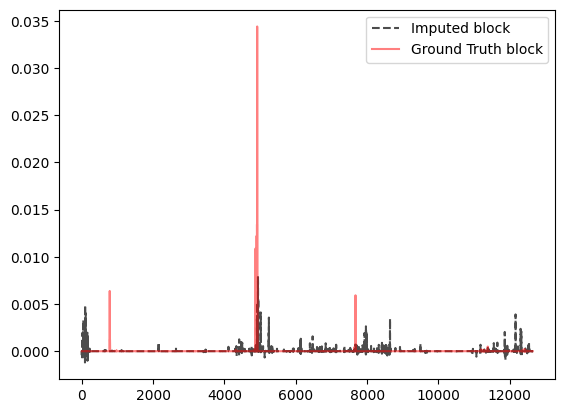

block RMSE: 0.00039725310290381386


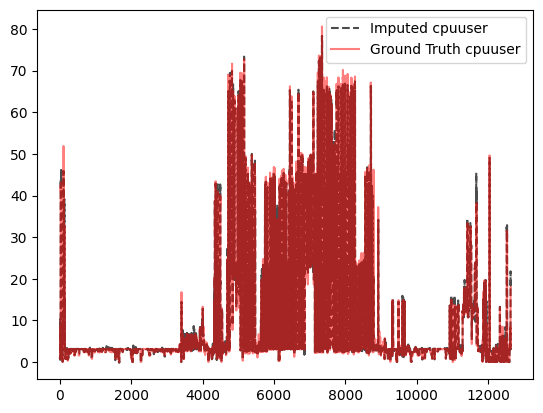

cpuuser RMSE: 1.296084317036147


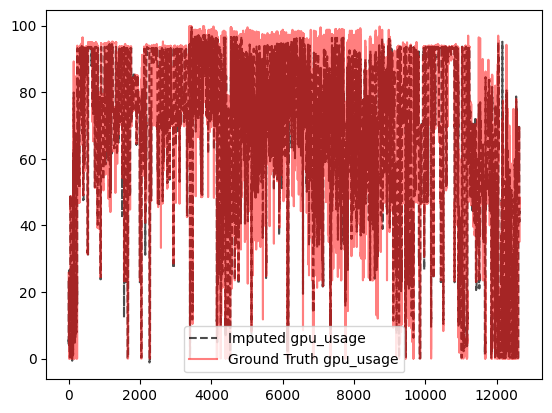

gpu_usage RMSE: 8.181182504118002


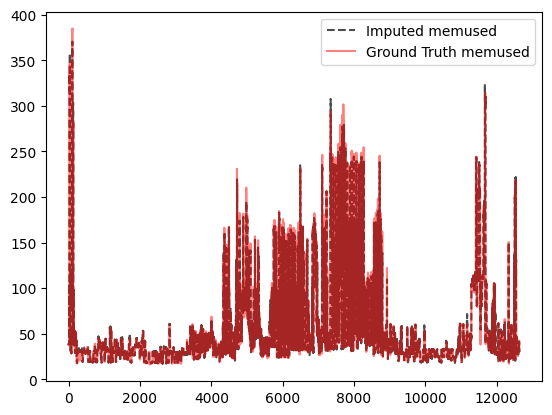

memused RMSE: 4.2211376413311905


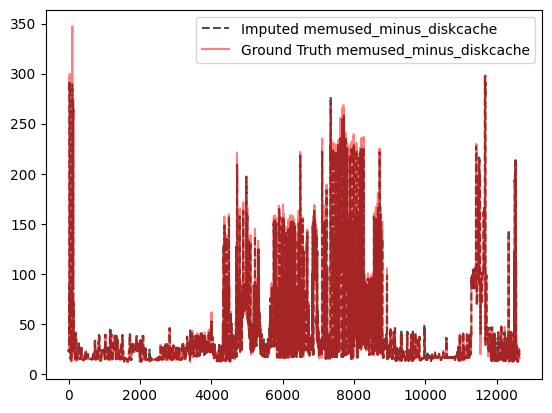

memused_minus_diskcache RMSE: 4.184904018011673


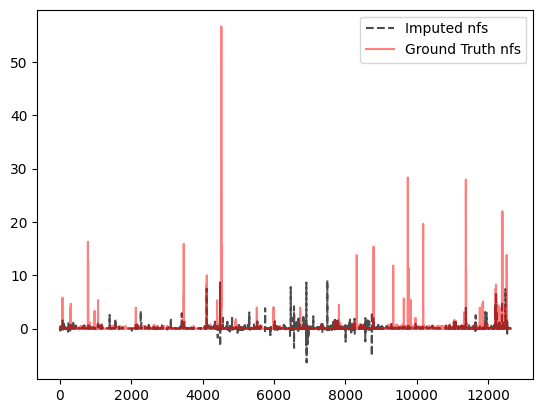

nfs RMSE: 0.9571105241311415


In [120]:
def trainer_prediction_output_to_df(output, idx: int, count: int):

    # Ensure ground truth is correctly reshaped
    truth_reshaped = output[1].reshape((count, 6))
    # Ensure all lengths match
    if all(len(output[0][i][:count]) == count for i in range(6)) and truth_reshaped.shape[0] == count:
        return pd.DataFrame({
            'block': list(output[0][0][:count]) + list(truth_reshaped[:, 0]),
            'cpuuser': list(output[0][1][:count]) + list(truth_reshaped[:, 1]),
            'gpu_usage': list(output[0][2][:count]) + list(truth_reshaped[:, 2]),
            'memused': list(output[0][3][:count]) + list(truth_reshaped[:, 3]),
            'memused_minus_diskcache': list(output[0][4][:count]) + list(truth_reshaped[:, 4]),
            'nfs': list(output[0][5][:count]) + list(truth_reshaped[:, 5]),
            'type': ['prediction'] * count + ['truth'] * count
        })
    else:
        raise ValueError("Mismatch between prediction and ground truth lengths.")



val_out = trainer_prediction_output_to_df([pred,y_val_lstm], 0,12642)
val_p = val_out[val_out['type']=='prediction']
val_t = val_out[val_out['type']=='truth'].reset_index(drop=True)
for col in forecast_columns:
  plt.plot(val_p.index, val_p[col], label=f'Imputed {col}', linestyle='--', color='black', alpha=0.7)
  plt.plot(val_t.index, val_t[col], label=f'Ground Truth {col}', linestyle='-', color='red', alpha=0.5)
  plt.legend()
  plt.show()
  plt.close()
  error = val_p[col].to_numpy()-val_t[col].to_numpy()
  errors_squared = error**2
  print(f"{col} RMSE: {math.sqrt(np.mean(errors_squared))}")

In [121]:
predictions = model_lstm.predict(X_val_lstm)

396/396 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


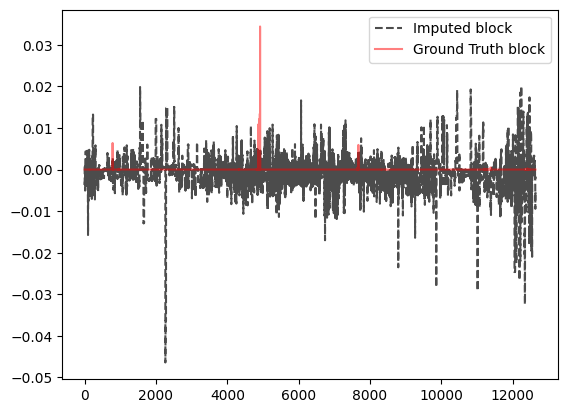

block RMSE: 0.004425134835022719


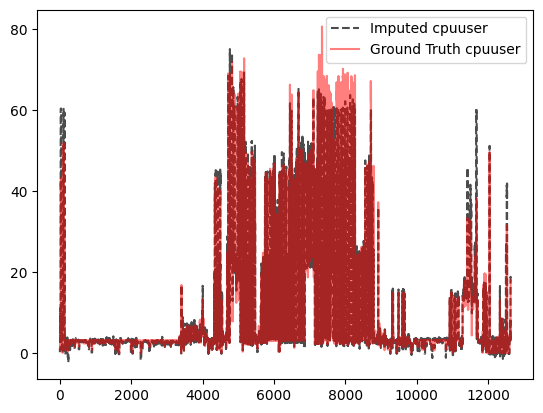

cpuuser RMSE: 2.3972969451042982


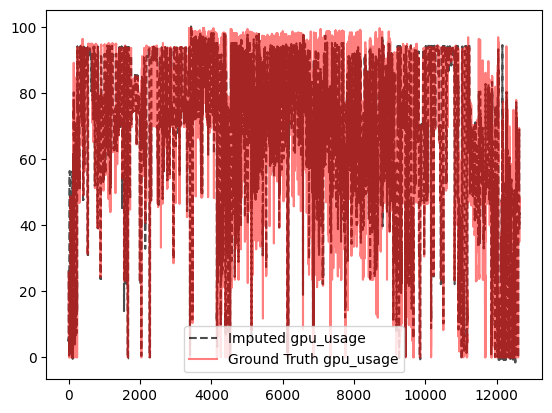

gpu_usage RMSE: 9.27579142894996


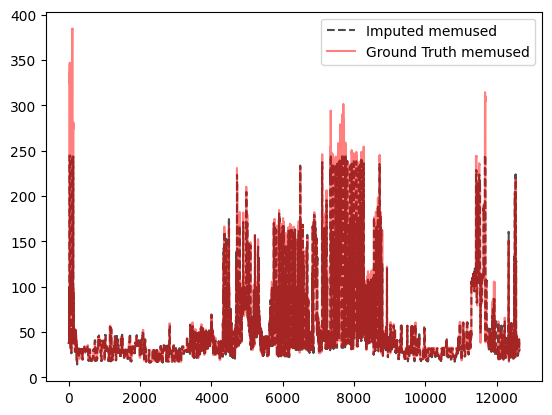

memused RMSE: 6.942498875985647


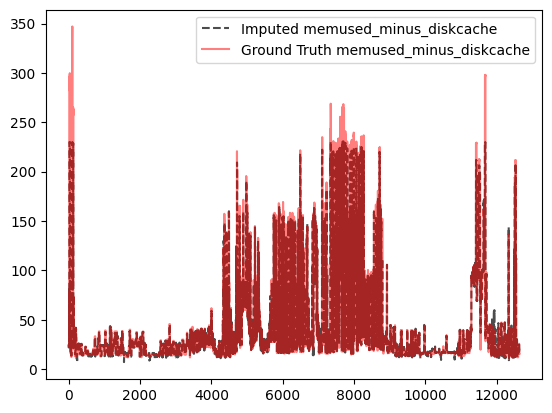

memused_minus_diskcache RMSE: 6.111746531313458


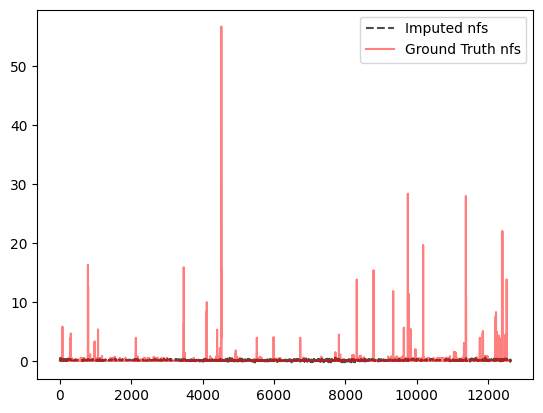

nfs RMSE: 0.9522123363451734


In [122]:
def trainer_prediction_output_to_df(output, idx:int, count:int):
    return pd.DataFrame({
        'block':list(output[0].reshape((count,6))[:, 0])+list(output[1].reshape((count,6))[:, 0]),
        'cpuuser':list(output[0].reshape((count,6))[:, 1])+list(output[1].reshape((count,6))[:, 1]),
        'gpu_usage':list(output[0].reshape((count,6))[:, 2])+list(output[1].reshape((count,6))[:, 2]),
        'memused':list(output[0].reshape((count,6))[:, 3])+list(output[1].reshape((count,6))[:, 3]),
        'memused_minus_diskcache':list(output[0].reshape((count,6))[:, 4])+list(output[1].reshape((count,6))[:, 4]),
        'nfs':list(output[0].reshape((count,6))[:, 5])+list(output[1].reshape((count,6))[:, 5]),
        'type':['prediction']*count + ['truth']*count
        })


val_out = trainer_prediction_output_to_df([predictions,y_val_lstm], 0,12642)
val_p = val_out[val_out['type']=='prediction']
val_t = val_out[val_out['type']=='truth'].reset_index(drop=True)
for col in forecast_columns:
  plt.plot(val_p.index, val_p[col], label=f'Imputed {col}', linestyle='--', color='black', alpha=0.7)
  plt.plot(val_t.index, val_t[col], label=f'Ground Truth {col}', linestyle='-', color='red', alpha=0.5)
  plt.legend()
  plt.show()
  plt.close()
  error = val_p[col].to_numpy()-val_t[col].to_numpy()
  errors_squared = error**2
  print(f"{col} RMSE: {math.sqrt(np.mean(errors_squared))}")

In [123]:
predictions = model_lstm.predict(X_test_missing_lstm)

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


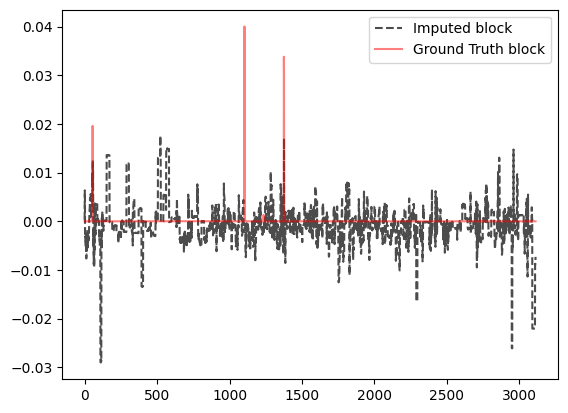

block RMSE: 0.004574715888753857


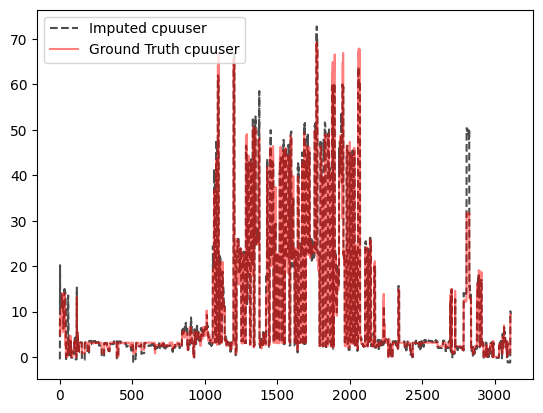

cpuuser RMSE: 2.179045254297778


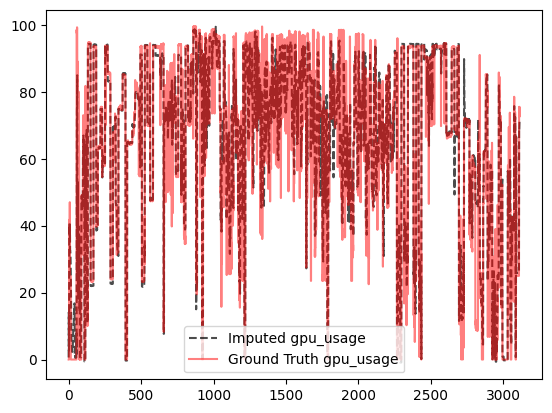

gpu_usage RMSE: 10.109742778341134


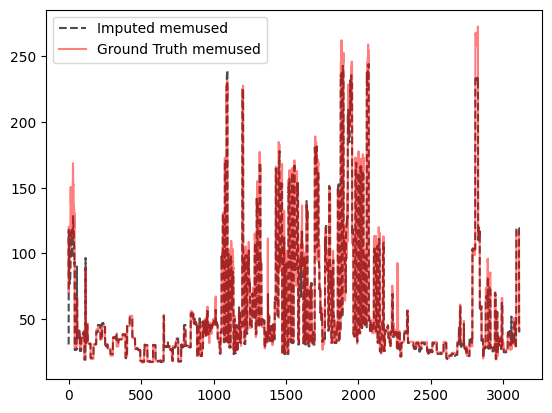

memused RMSE: 6.964608903148943


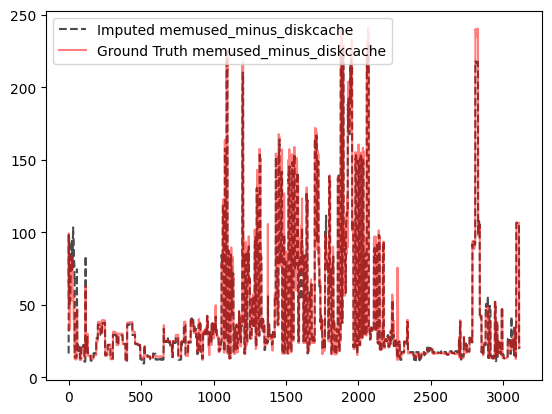

memused_minus_diskcache RMSE: 6.513852319695406


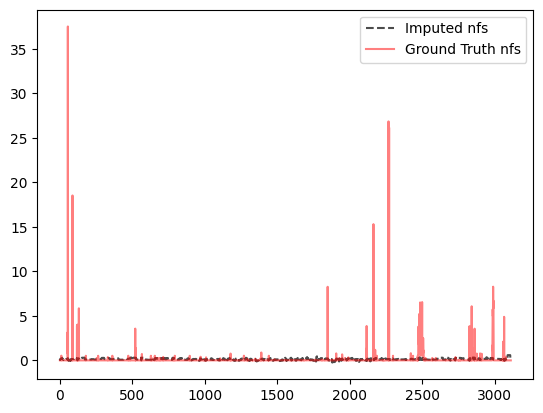

nfs RMSE: 1.161978081868948


In [133]:
def trainer_prediction_output_to_df(output, idx:int, count:int):
    return pd.DataFrame({
        'block':list(output[0].reshape((count,6))[:, 0])+list(output[1].reshape((count,6))[:, 0]),
        'cpuuser':list(output[0].reshape((count,6))[:, 1])+list(output[1].reshape((count,6))[:, 1]),
        'gpu_usage':list(output[0].reshape((count,6))[:, 2])+list(output[1].reshape((count,6))[:, 2]),
        'memused':list(output[0].reshape((count,6))[:, 3])+list(output[1].reshape((count,6))[:, 3]),
        'memused_minus_diskcache':list(output[0].reshape((count,6))[:, 4])+list(output[1].reshape((count,6))[:, 4]),
        'nfs':list(output[0].reshape((count,6))[:, 5])+list(output[1].reshape((count,6))[:, 5]),
        'type':['prediction']*count + ['truth']*count
        })

val_out = trainer_prediction_output_to_df([predictions,y_test_lstm], 0,3113)
val_p = val_out[val_out['type']=='prediction']
val_t = val_out[val_out['type']=='truth'].reset_index(drop=True)
for col in forecast_columns:
  plt.plot(val_p.index, val_p[col], label=f'Imputed {col}', linestyle='--', color='black', alpha=0.7)
  plt.plot(val_t.index, val_t[col], label=f'Ground Truth {col}', linestyle='-', color='red', alpha=0.5)
  plt.legend()
  plt.show()
  plt.close()
  error = val_p[col].to_numpy()-val_t[col].to_numpy()
  errors_squared = error**2
  print(f"{col} RMSE: {math.sqrt(np.mean(errors_squared))}")

In [134]:
predictions = val_out[val_out['type'] == 'prediction'].drop(columns=['type']).reset_index(drop=True)
truth_values = val_out[val_out['type'] == 'truth'].drop(columns=['type']).reset_index(drop=True)

filled_data = test_data.copy()  # Create a copy to avoid modifying the original data

for column in ['block', 'cpuuser', 'gpu_usage', 'memused', 'memused_minus_diskcache', 'nfs']:
    # Use where() to fill NaNs in the original dataset with predictions
    filled_data[column] = truth_values[column].where(~test_data[column].isna(), predictions[column])


In [150]:
from sklearn.metrics import mean_squared_error
import math

# Reorder the imputed, test, and test_missing dfs so they are all aligned
# imputed_df = imputed_df.reset_index().sort_values([*groupby_cols, 'timestamp']).reset_index(drop=True)
erer = filled_data.sort_values([*groupby_cols]).reset_index(drop=True)
naive_imputed_df = test_missing_df.copy()

erer.head()


# # Fill missing values using the naive mean fill for comparison
naive_imputed_df[event_cols] = test_missing_df[event_cols].fillna(test_missing_df[event_cols].mean())

# # Get indices of rows with missing values
nan_idxs = test_missing_df[test_missing_df[event_cols].isna().any(axis=1)].index
print(len(predictions))
# Loop through each column in event_cols to calculate and print RMSE
# for col in event_cols:
#     hybrid_rmse = math.sqrt(mean_squared_error(erer.loc[nan_idxs, col], test_df.loc[nan_idxs, col]))
# #     naive_rmse = math.sqrt(mean_squared_error(naive_imputed_df.loc[nan_idxs, col], test_df.loc[nan_idxs, col]))

# #     print(f"RMSE for {col} - Hybrid model: {hybrid_rmse}")
# #     print(f"RMSE for {col} - Naive mean: {naive_rmse}")


3113


In [145]:
erer.head()

,job_id,host,timestamp,block,cpuuser,gpu_usage,memused,memused_minus_diskcache,nfs,relative_index,time_since_job_start,new_block,new_cpuuser,new_gpu_usage,new_memused,new_memused_minus_diskcache,new_nfs
0,JOB1109704,NODE185,2023-04-17 18:35:02,1.271488e-07,0.011848,0.0,28.248428,12.421261,0.0,48,5760,1.271549e-07,0.105275,0.0,33.171469,12.338777,0.001163
1,JOB1109704,NODE185,2023-04-17 18:37:02,1.271666e-07,0.015366,0.0,28.264595,12.437187,0.0,49,5880,1.271557e-07,0.236463,0.0,36.695724,16.648005,0.001174
2,JOB1109704,NODE185,2023-04-17 18:39:02,1.271485e-07,0.014257,0.0,28.275623,12.449249,0.0,50,6000,1.271557e-07,1.355439,0.0,47.542010,27.484706,0.002708
3,JOB1109704,NODE185,2023-04-17 18:41:02,1.271579e-07,0.010287,0.0,28.269619,12.442883,0.0,51,6120,1.271566e-07,2.060136,0.0,54.672654,34.606194,0.004843
4,JOB1109704,NODE185,2023-04-17 18:43:02,1.271610e-07,0.018360,0.0,28.269840,12.443394,0.0,52,6240,1.377538e-07,2.599717,0.0,54.787201,33.928867,0.004039
